# Import the libraries and packages

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16 #transfer learning structure
import matplotlib.pyplot as plt
import os

print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.19.0


##Make and load the dataset

In [13]:
!unzip skin-disease-dataset.zip

Archive:  skin-disease-dataset.zip
   creating: skin-disease-datasaet/
   creating: skin-disease-datasaet/athlete-foot/
  inflating: skin-disease-datasaet/athlete-foot/FU-athlete-foot (1).jpeg  
  inflating: skin-disease-datasaet/athlete-foot/FU-athlete-foot (1).jpg  
  inflating: skin-disease-datasaet/athlete-foot/FU-athlete-foot (1).png  
  inflating: skin-disease-datasaet/athlete-foot/FU-athlete-foot (10).jpeg  
  inflating: skin-disease-datasaet/athlete-foot/FU-athlete-foot (10).jpg  
  inflating: skin-disease-datasaet/athlete-foot/FU-athlete-foot (11).jpeg  
  inflating: skin-disease-datasaet/athlete-foot/FU-athlete-foot (11).jpg  
  inflating: skin-disease-datasaet/athlete-foot/FU-athlete-foot (12).jpeg  
  inflating: skin-disease-datasaet/athlete-foot/FU-athlete-foot (12).jpg  
  inflating: skin-disease-datasaet/athlete-foot/FU-athlete-foot (13).jpeg  
  inflating: skin-disease-datasaet/athlete-foot/FU-athlete-foot (13).jpg  
  inflating: skin-disease-datasaet/athlete-foot/FU-at

In [17]:
dataset_path = "/content/skin-disease-datasaet"

image_size = (224, 224) #size of the images which suitable for VGG16
batch_size = 16 #the images that gives to the model at once

##Find the corrupted images

In [18]:
print("\nChecking for corrupted images...")
class_names_list = [
    "cellulitis", "impetigo", "athlete-foot", "nail-fungus",
    "ringworm", "cutaneous-larva-migrans", "chickenpox", "shingles"
]

num_skipped = 0
for folder_name in class_names_list:
    folder_path = os.path.join(dataset_path, folder_name)
    if not os.path.isdir(folder_path):
        print(f"Warning: Folder not found at {folder_path}, skipping.")
        continue

    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print(f"--> Deleted {num_skipped} corrupted images.")


Checking for corrupted images...
--> Deleted 21 corrupted images.


##Create training and validation datasets

In [20]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

print("\nDatasets loaded successfully...")
class_names = train_ds.class_names
print(f"Found classes: {class_names}")

Found 1106 files belonging to 8 classes.
Using 885 files for training.
Using 221 files for validation.

Datasets loaded successfully...
Found classes: ['athlete-foot', 'cellulitis', 'chickenpox', 'cutaneous-larva-migrans', 'impetigo', 'nail-fungus', 'ringworm', 'shingles']


#Visualize the data


Displaying sample images from the training dataset...


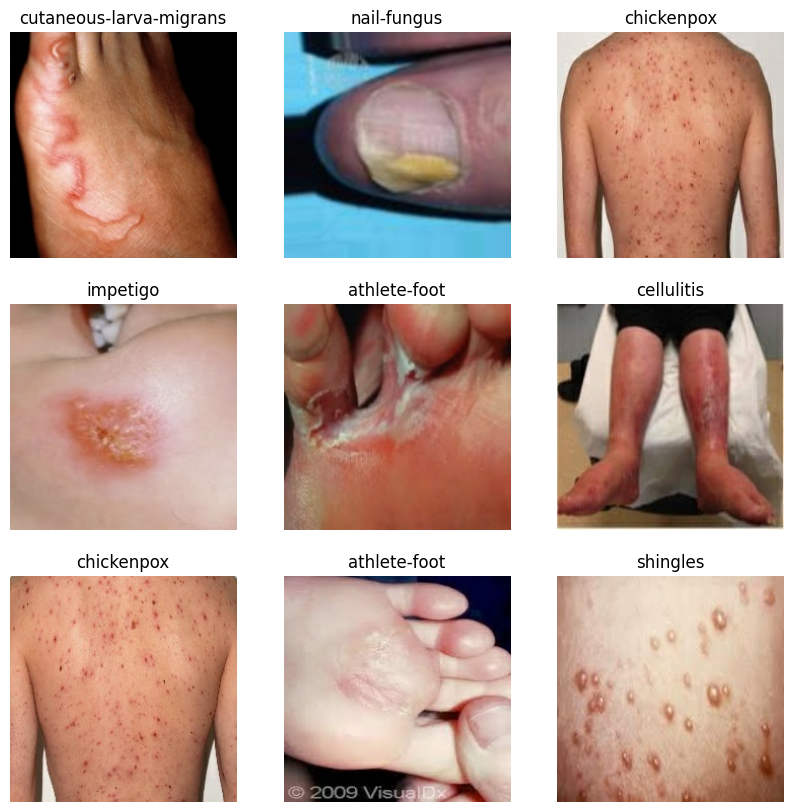

In [21]:
print("\nDisplaying sample images from the training dataset...")

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

#Create the structure for transfer learning

In [22]:
#load the pretrained VGG16 structure
#'imagenet' means the knowledge learned by huge images dataset
# 'include_top=False' removes the last decision layer in VGG16.
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [23]:
#Freeze the BaseModel layers
#This is done to prevent changes to the knowledge already in VGG16.
base_model.trainable = False

print("--> VGG16 base model loaded and layers are frozen.")

--> VGG16 base model loaded and layers are frozen.


In [24]:
# Adding our own new decision layers
# In place of the removed decision layer, add a new layer that identifies our 8 disease types.
model = keras.Sequential([
    base_model, #VGG16 that has knowledge
    layers.GlobalAveragePooling2D(), #The layer that summarizing Feature
    layers.Dropout(0.5), #reduce overfitting
    layers.Dense(8, activation="softmax") #8 disease types
])

print("--> New classification head added to the base model.")

--> New classification head added to the base model.


##Compiling the model (preparing for training)

In [25]:
print("\nCompiling the model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', #because there are more than 2 classes
    metrics=['accuracy']
)
print("--> Model compiled successfully.")
model.summary()


Compiling the model...
--> Model compiled successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,718,792 (56.15 MB)

 Trainable params: 4,104 (16.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

##Model Training

In [26]:
print("\nStarting model training...")

epochs = 15

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

print("--> Model training completed.")


Starting model training...
Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 646s 12s/step - accuracy: 0.1642 - loss: 8.6942 - val_accuracy: 0.4072 - val_loss: 2.4443
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 693s 12s/step - accuracy: 0.3161 - loss: 5.0153 - val_accuracy: 0.6652 - val_loss: 1.1756
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 682s 12s/step - accuracy: 0.5054 - loss: 3.2599 - val_accuracy: 0.7738 - val_loss: 0.7893
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 684s 12s/step - accuracy: 0.5746 - loss: 2.3783 - val_accuracy: 0.8462 - val_loss: 0.5929
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 656s 12s/step - accuracy: 0.6232 - loss: 1.7884 - val_accuracy: 0.8824 - val_loss: 0.4362
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 682s 12s/step - accuracy: 0.6667 - loss: 1.6623 - val_accuracy: 0.8824 - val_loss: 0.3427
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 682s 12s/step - accuracy: 0.7413 - loss: 1.2397 - val_accuracy: 0.9095 - val_loss: 0.3237
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 657s 12s/step - accuracy: 0.8048 - los

##Analyze Results


Plotting training history...


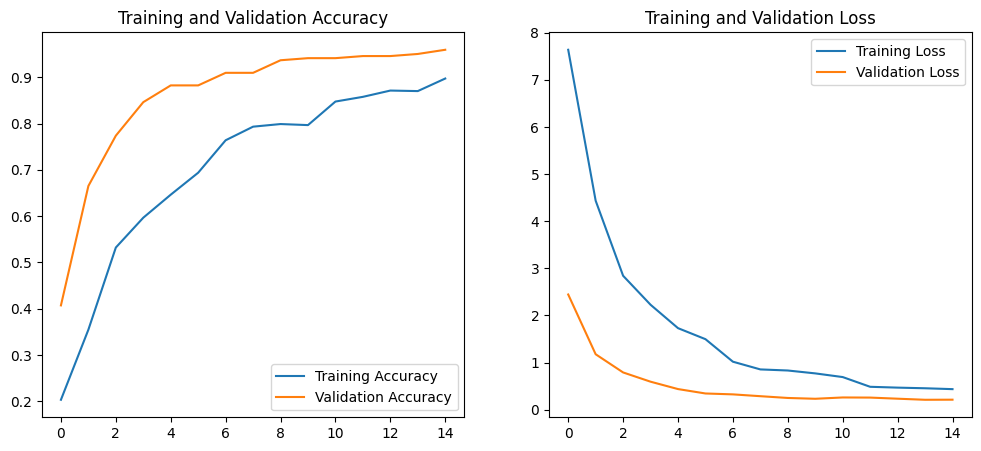

In [27]:
print("\nPlotting training history...")

#analyze the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Analyze loss
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


##test

In [28]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

In [30]:
img_path = "/content/athletefoot.jpeg"

#preprocess the image
img = load_img(img_path, target_size=(224,224))

#translate the image to an array which the model can understand
img_array = img_to_array(img)

#Since the model expects a batch of images,
# adding an extra dimension to our single image.
img_array_expanded = np.expand_dims(img_array, axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step

--- Prediction Result ---


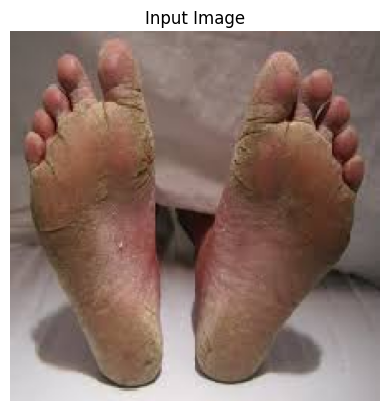

Predicted Class: 'athlete-foot'
Confidence: 99.99%


In [33]:
#get the prediction
prediction = model.predict(img_array_expanded)

#understand the result and show
# The output from the model is a list of probabilities for all 8 classes.
# For example: [0.01, 0.05, 0.92, 0.01, 0.0, 0.0, 0.01, 0.0]

# Get the index of the class with the highest probability
predicted_index = np.argmax(prediction[0])

# Get the name of the class corresponding to that index from our class_names list
# (class_names is the list originally obtained from train_ds.class_names)
predicted_class = class_names[predicted_index]

# Obtaining the confidence score of the prediction
confidence_score = np.max(prediction[0]) * 100

#final result
print("\n--- Prediction Result ---")
plt.imshow(img)
plt.title(f"Input Image")
plt.axis("off")
plt.show()

print(f"Predicted Class: '{predicted_class}'")
print(f"Confidence: {confidence_score:.2f}%")




In [34]:
def predict_single_image(image_path, model, class_names):
  try:
    img = load_img(image_path, target_size=(224,224))
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array_expanded)

    predicted_index = np.argmax(prediction[0])
    predicted_class = class_names[predicted_index]
    confidence_score = np.max(prediction[0]) * 100

    return predicted_class, confidence_score, img
  except FileNotFoundError:
    print(f"Error: The file was not found at {image_path}")
    return None, None, None



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
Predicted Class: 'cellulitis'
Confidence: 71.51%


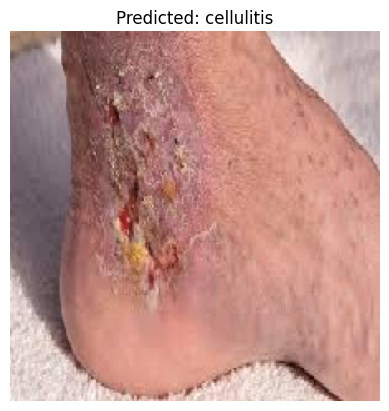

In [44]:
#test_image_path = "/content/athletefoot.jpeg"
#test_image_path = "/content/cutaneous-larva-migrans.jpeg"
#test_image_path = "/content/chickenpox.jpeg"
#test_image_path = "/content/impetigo.jpeg"
#test_image_path = "/content/nailfungus.jpeg"
#test_image_path = "/content/ringworm.jpeg"
#test_image_path = "/content/shingles.jpeg"
test_image_path = "/content/cellulitis.jpeg"


predicted_class, confidence, img = predict_single_image(test_image_path, model, class_names)

if predicted_class:
    print(f"Predicted Class: '{predicted_class}'")
    print(f"Confidence: {confidence:.2f}%")
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()

In [45]:
model.save("skin_disease_model.keras")

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
!cp skin_disease_model.keras "/content/drive/My Drive/"